# **WEEK 5 - LSTM Models**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [ ]:
df = pd.read_csv('ReviewTokoBaju.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [ ]:
# 2. Preprocessing - Data Cleaning
df.dropna(subset=['Review Text', 'Recommended IND'], inplace=True)

In [ ]:
# Selecting the features and label
X = df['Review Text'].values
y = df['Recommended IND'].values

In [ ]:
# Label Encoding for the target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Tokenization and padding using Keras (for TensorFlow model)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100  # Max sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Convert labels to tensor for PyTorch
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

In [ ]:
# PyTorch Model with Embedding Layer (LSTM)
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)  # Convert word indices into embeddings
        out, (hn, cn) = self.lstm(x)  # LSTM layer
        out = self.fc(out[:, -1, :])  # Taking the output of the last time step
        return self.sigmoid(out)

In [ ]:
# Hyperparameters for LSTM Model
vocab_size = 5000  # Number of unique words in the vocabulary (as defined in Tokenizer)
embedding_dim = 128  # Dimensionality of embedding space
hidden_size = 128  # Number of hidden units in LSTM
output_size = 1  # Binary classification
model = LSTMModel(vocab_size, embedding_dim, hidden_size, output_size)

In [ ]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop for PyTorch
num_epochs = 10
train_loss = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Convert data to tensor
    inputs = torch.tensor(X_train_pad, dtype=torch.long)  # Use long type for word indices
    targets = y_train_tensor.float().view(-1, 1)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.7012
Epoch [2/10], Loss: 0.6848
Epoch [3/10], Loss: 0.6691
Epoch [4/10], Loss: 0.6537
Epoch [5/10], Loss: 0.6383
Epoch [6/10], Loss: 0.6225
Epoch [7/10], Loss: 0.6060
Epoch [8/10], Loss: 0.5885
Epoch [9/10], Loss: 0.5698
Epoch [10/10], Loss: 0.5495


In [27]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_inputs = torch.tensor(X_test_pad, dtype=torch.long)  # Use long type for word indices
    test_outputs = model(test_inputs)
    test_predictions = test_outputs.round().view(-1).numpy()

In [28]:
# Compute additional metrics for PyTorch model
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_predictions)
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)

# Print metrics for PyTorch
print(f"Accuracy (PyTorch): {accuracy:.4f}")
print(f"Precision (PyTorch): {precision:.4f}")
print(f"Recall (PyTorch): {recall:.4f}")
print(f"F1-Score (PyTorch): {f1:.4f}")
print(f"AUC (PyTorch): {roc_auc:.4f}")

Accuracy (PyTorch): 0.8192
Precision (PyTorch): 0.8209
Recall (PyTorch): 0.9973
F1-Score (PyTorch): 0.9005
AUC (PyTorch): 0.5005


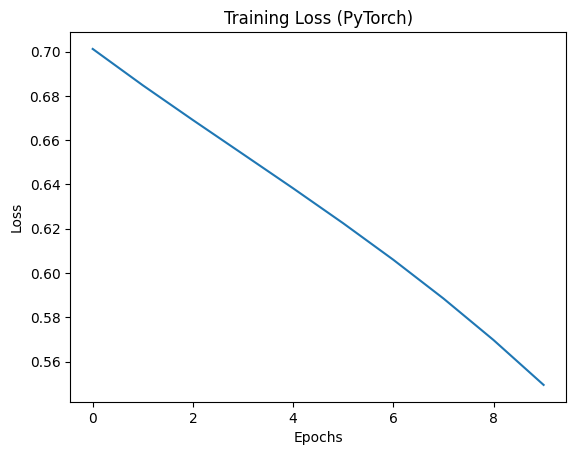

In [ ]:
# Plot loss
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss (PyTorch)')
plt.show()

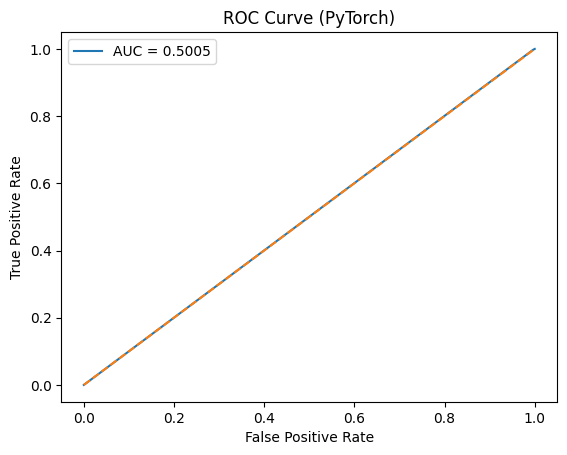

In [29]:
# Plot ROC curve for PyTorch
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve (PyTorch)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# 4. TensorFlow Model (LSTM)
model_tf = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train the TensorFlow model
history = model_tf.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8418 - loss: 0.3921 - val_accuracy: 0.8836 - val_loss: 0.2656
Epoch 2/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9097 - loss: 0.2271 - val_accuracy: 0.8951 - val_loss: 0.2508
Epoch 3/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9326 - loss: 0.1697 - val_accuracy: 0.8858 - val_loss: 0.2605
Epoch 4/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9398 - loss: 0.1554 - val_accuracy: 0.8843 - val_loss: 0.2842
Epoch 5/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9513 - loss: 0.1187 - val_accuracy: 0.8850 - val_loss: 0.3235
Epoch 6/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9649 - loss: 0.0948 - val_accuracy: 0.8755 - val_loss: 0.3698
Epoch 7/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9712 - loss: 0.0781 - val_accuracy: 0.8752 - val_loss: 0.3898
Epoch 8/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9789 - loss: 0.0606 - val_accuracy: 0.

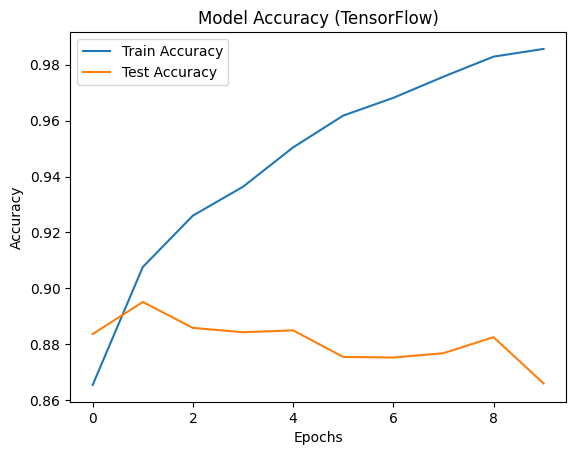

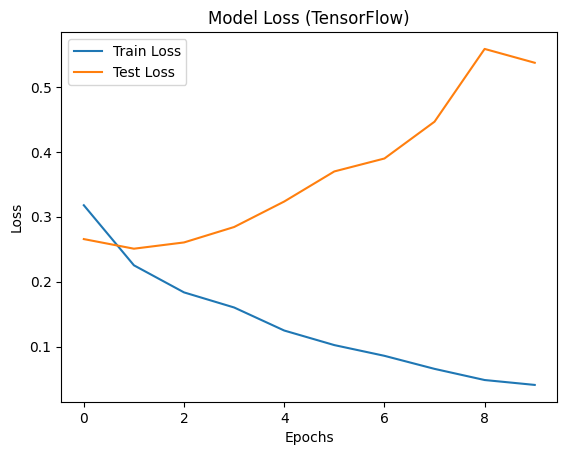

In [ ]:
# Plot training & validation accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy (TensorFlow)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss (TensorFlow)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 5. Evaluate Models - TensorFlow

# Evaluate on test set
test_loss, test_acc = model_tf.evaluate(X_test_pad, y_test)
print(f"Test Accuracy (TensorFlow): {test_acc:.4f}")
print(f"Test Loss (TensorFlow): {test_loss:.4f}")

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8555 - loss: 0.5822
Test Accuracy (TensorFlow): 0.8660
Test Loss (TensorFlow): 0.5372


In [24]:
# Predict the probabilities for the positive class
y_pred_prob = model_tf.predict(X_test_pad)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [25]:
# Compute additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Print metrics
print(f"Accuracy (TensorFlow): {accuracy:.4f}")
print(f"Precision (TensorFlow): {precision:.4f}")
print(f"Recall (TensorFlow): {recall:.4f}")
print(f"F1-Score (TensorFlow): {f1:.4f}")
print(f"AUC (TensorFlow): {roc_auc:.4f}")

Accuracy (TensorFlow): 0.8660
Precision (TensorFlow): 0.9096
Recall (TensorFlow): 0.9290
F1-Score (TensorFlow): 0.9192
AUC (TensorFlow): 0.8856


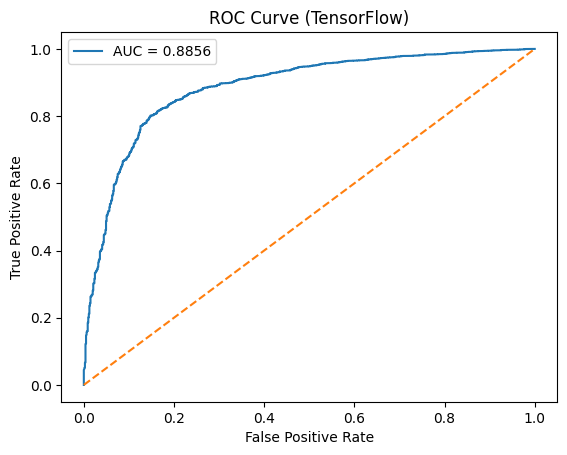

In [26]:
# Plot ROC curve for TensorFlow
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve (TensorFlow)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# **Hasil Evaluasi Model:**

| **Metrik**     | **Nilai (PyTorch)** | **Nilai (TensorFlow)** |
|----------------|---------------------|------------------------|
| **Accuracy**   | 0.8192              | 0.8660                 |
| **Precision**  | 0.8209              | 0.9096                 |
| **Recall**     | 0.9973              | 0.9290                 |
| **F1-Score**   | 0.9005              | 0.9192                 |
| **AUC**        | 0.5005              | 0.8856                 |

#### **PyTorch**:
- **Accuracy (PyTorch)**: 0.8192
  - Akurasi menunjukkan seberapa banyak prediksi yang benar dari keseluruhan data uji. Dalam hal ini, model PyTorch berhasil memprediksi dengan benar sekitar 81.92% dari data yang diuji.

- **Precision (PyTorch)**: 0.8209
  - Precision mengukur berapa banyak dari prediksi positif yang benar-benar positif (True Positives). Artinya, dari semua prediksi positif yang dilakukan oleh model, sekitar 82.09% adalah benar. Precision yang tinggi menunjukkan bahwa model tidak banyak membuat prediksi positif yang salah (False Positives).

- **Recall (PyTorch)**: 0.9973
  - Recall mengukur seberapa banyak dari data yang sebenarnya positif yang berhasil diprediksi dengan benar oleh model. Model PyTorch memiliki recall yang sangat tinggi, yaitu 99.73%, yang berarti hampir semua contoh positif terdeteksi oleh model.

- **F1-Score (PyTorch)**: 0.9005
  - F1-Score adalah rata-rata harmonis dari Precision dan Recall. F1-Score yang lebih tinggi menunjukkan keseimbangan antara Precision dan Recall. Dalam hal ini, F1-Score sebesar 0.9005 menunjukkan bahwa model PyTorch memiliki keseimbangan yang baik antara meminimalkan False Positives dan False Negatives.

- **AUC (PyTorch)**: 0.5005
  - AUC (Area Under the Curve) mengukur kemampuan model untuk membedakan antara kelas positif dan negatif. AUC yang mendekati 1 menunjukkan model yang sangat baik dalam membedakan antara kelas positif dan negatif, sementara AUC yang mendekati 0.5 menunjukkan model yang hampir tidak lebih baik dari tebakan acak. Nilai AUC 0.5005 pada model PyTorch menunjukkan bahwa model ini hanya sedikit lebih baik daripada tebakan acak.

#### **TensorFlow**:
- **Accuracy (TensorFlow)**: 0.8660
  - Akurasi model TensorFlow menunjukkan bahwa model ini berhasil memprediksi dengan benar sekitar 86.60% dari data uji. Ini menunjukkan kinerja yang lebih baik dibandingkan dengan model PyTorch.

- **Precision (TensorFlow)**: 0.9096
  - Precision yang tinggi (90.96%) menunjukkan bahwa model TensorFlow menghasilkan sedikit False Positives. Dari semua prediksi positif yang dilakukan, 90.96% adalah benar-benar positif.

- **Recall (TensorFlow)**: 0.9290
  - Recall sebesar 92.90% menunjukkan bahwa model TensorFlow berhasil mendeteksi hampir 93% dari semua contoh positif yang ada dalam data uji.

- **F1-Score (TensorFlow)**: 0.9192
  - F1-Score sebesar 0.9192 menunjukkan keseimbangan yang sangat baik antara Precision dan Recall pada model TensorFlow. Ini menunjukkan bahwa model berhasil menjaga keseimbangan antara tidak terlalu banyak False Positives dan tidak terlalu banyak False Negatives.

- **AUC (TensorFlow)**: 0.8856
  - AUC yang lebih tinggi pada model TensorFlow, yaitu 0.8856, menunjukkan bahwa model ini jauh lebih baik dalam membedakan antara kelas positif dan negatif dibandingkan model PyTorch. Model TensorFlow memiliki kemampuan yang sangat baik untuk memisahkan kedua kelas ini.

---

### Penjelasan untuk Setiap Persamaan Matematika:

1. **Accuracy (Akurasi)**:
   - **Persamaan**:
  
$$\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}$$


Persamaan ini digunakan untuk menghitung akurasi, yang merupakan rasio antara jumlah prediksi yang benar (baik untuk kelas positif maupun negatif) terhadap total sampel yang diuji.
     
     - True Positives (TP): Jumlah prediksi yang benar untuk kelas positif.
     - True Negatives (TN): Jumlah prediksi yang benar untuk kelas negatif.
     - Total Samples: Jumlah total sampel dalam dataset uji.
   
   - Makna: Akurasi mengukur seberapa baik model dalam membuat prediksi yang benar, baik untuk kelas positif maupun negatif.

2. **Precision**:
   - **Persamaan**:
     
     $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$
     
     - False Positives (FP): Jumlah prediksi yang salah untuk kelas positif (model memprediksi positif padahal sebenarnya negatif).
   
   - Makna: Precision menunjukkan seberapa akurat model dalam memprediksi kelas positif. Precision yang tinggi berarti model jarang membuat kesalahan dalam memprediksi kelas positif.

3. **Recall**:
   - **Persamaan**:
     
     $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
     
     - False Negatives (FN): Jumlah prediksi yang salah untuk kelas negatif (model memprediksi negatif padahal sebenarnya positif).
   
   - Makna: Recall mengukur seberapa baik model dalam mendeteksi semua kelas positif yang sebenarnya. Recall yang tinggi berarti model sangat baik dalam mendeteksi kelas positif, meskipun ada kemungkinan memprediksi lebih banyak False Positives.

4. **F1-Score**:
   - **Persamaan**:
     
     $$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
     
   
   - Makna: F1-Score adalah rata-rata harmonis antara Precision dan Recall. Ini digunakan untuk menilai keseimbangan antara Precision dan Recall, terutama ketika ada ketidakseimbangan kelas. F1-Score yang tinggi menunjukkan keseimbangan yang baik antara meminimalkan False Positives dan False Negatives.

5. **AUC (Area Under the Curve)**:
   - **Persamaan**: AUC dihitung sebagai area di bawah kurva ROC.
     - ROC Curve adalah grafik yang menggambarkan hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR).
     - TPR (True Positive Rate): Juga dikenal sebagai Recall.
     - FPR (False Positive Rate): Dihitung sebagai:
       
       $$\text{FPR} = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}$$
       
   
   - Makna: AUC mengukur kemampuan model dalam membedakan antara kelas positif dan negatif. AUC yang lebih tinggi menunjukkan kemampuan model yang lebih baik dalam membedakan kedua kelas ini.

6. **ROC Curve**:
   - **Persamaan**: ROC adalah grafik yang menggambarkan TPR vs FPR.
     - TPR (True Positive Rate) atau Recall:
       
       $$\text{TPR} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
       
     - FPR (False Positive Rate):
       
       $$\text{FPR} = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}$$
       
   
   - Makna: ROC Curve adalah alat visual yang menggambarkan trade-off antara True Positive Rate dan False Positive Rate di berbagai threshold. AUC yang lebih tinggi menunjukkan model yang lebih baik.

---

### Kesimpulan:
- TensorFlow menunjukkan performa yang lebih baik daripada PyTorch, dengan AUC yang lebih tinggi, akurasi lebih baik, dan precision yang lebih tinggi.
- PyTorch memiliki Recall yang sangat tinggi, yang berarti model ini sangat baik dalam mendeteksi contoh positif, namun AUC yang rendah menunjukkan bahwa model kurang baik dalam membedakan antara kelas positif dan negatif.
- TensorFlow lebih seimbang dalam hal Precision dan Recall, dengan AUC yang menunjukkan kemampuan model untuk membedakan kedua kelas dengan lebih baik.

Secara keseluruhan, model TensorFlow lebih baik dalam hal kinerja keseluruhan berdasarkan metrik yang diberikan, sementara model PyTorch memiliki performa yang sangat baik dalam hal deteksi kelas positif.